# Project 3: Transformer BoolQ

The documentation is split into small chunks following the suggestion in class and from feedback for previous projects.

# Introduction

Classification of BoolQ with Transformers.

Minimal preprocessing was done on the BoolQ dataset. Only lower casing and removal of special characters. Then `question` and `passage` are concatenated to be the input for the learned word embeddings. With an embedding dimension of 512.

With an positional encoding or embedding being done after the word embeddings. That is the input to the following transformer layers.

A classification model with 6 Transformer layers is created and connected with 2 linear layers for outputting the probability if the passage answers the question.
The linear layers are connected through ReLu and Sigmoid is used to output the probabilities.

Experiments were made with various hyperparameters configuations to determine which works best. Those were positional encoding type, learning rate and amount of attention heads.

The final model was with position embedding, learning rate 1-e4 and 8 attention heads.

With following performances:
- Accuracy: 0.6287
- Loss: 0.6640
- Recall: 0
- Specificty: 0

W&B Link: https://wandb.ai/yelin-zhang-hslu/nlp-project-3/sweeps/zmgqc6oi?nw=nwuseryelinzhang

# Setup
Preliminary steps for setting getting the project running.

## Tools used
- GPUHub JupyterLab
- Pytorch Lightning documentation
- No AI tools used, as they do not help with reading API documentation and GitHub issues 
- Previous projects documentation

## Dependencies
The notebook was created with:
Python 3.11.9

Install all necessary dependencies
- PyTorch: `torch torchtext torchtune torchao lightning`
- Hugging Face: `huggingface_hub datasets`
- Weights & Biases: `wandb`
- nltk: `nltk`
- numpy: `numpy`
- scikit-learn: `scikit-learn`
- Lint and Formatting: `ruff`

Versions of dependencies are pinned for reproducibility.

In [1]:
%pip install torch==2.3.1 torchtext==0.18.0 torchtune==0.3.1 torchao==0.6.1 lightning==2.4.0 huggingface_hub==0.25.2 datasets==3.0.1 wandb==0.18.3 nltk==3.9.1 numpy==1.26.4 scikit-learn==1.5.2 ruff==0.6.9

Note: you may need to restart the kernel to use updated packages.


## Notebook setup
Import all necessary libraries.

In [30]:
from datasets import load_dataset
from pathlib import Path
import shutil
from huggingface_hub import hf_hub_download
from datasets import Value
import wandb
from lightning.pytorch.loggers import WandbLogger
from torchtext.vocab import build_vocab_from_iterator
import torchmetrics
from torch import optim, nn, utils
import lightning as L
import nltk
from nltk.tokenize import PunktTokenizer
import torch
import string
import numpy as np
from torchtune.modules import RotaryPositionalEmbeddings
from sklearn.metrics import ConfusionMatrixDisplay

Log into Hugging Face and Weights & Biases.

In [3]:
%env "WANDB_NOTEBOOK_NAME" "project3-stage2"
wandb.login()
WANDB_PROJECT = "nlp-project-3"

env: "WANDB_NOTEBOOK_NAME"="project3-stage2"


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yelin-zhang (yelin-zhang-hslu). Use `wandb login --relogin` to force relogin


# Preprocessing

Predefined requirements:
- Download the BoolQ dataset with `datasets` and split it in the predefined way.
- Train / Validation / Test split

Used features:
- `question` and `passage` as word vectors
- `answer` as label

Input format:
- concatenated `question` and `passage` word vectors
- with a special seperator token in the middle to differentiate between them
- the ordering should not matter as transformers do not have sequential processing like RNNs

Label format:
- convert `answer` boolean to 1 or 0
- Model output is probability of 1
- `dataset.cast_column("answer", Value("int32"))`

Batch size: 64 for faster training than with individual samples

Why not:
- Stemming/ Lemmatization
    - Removes potential information about how the word is used. Which is important for answering questions.
- Removal of other words/ stopwords
    - Stopwords are important to answering the question, as negations and other important words are counted as stopwords.
    - Some words might be worth removing (wikipedia parsing errors, tooltip text in paragraph), but the required effort for minimal gains are not work.
- Format cleaning
    - Other than removing non ascii words there no cleaning is needed.
    - Because looking through some examples of the data it reads like the intended text.
- Truncation
    - As discussed in class: information will be lost. As input sizes are not a problem, this is not needed.
- Padding
    - As discussed in class: Padding will be done for each batch indivdually, instead of padding all passages to the same length.


## Correctness tests
- Check processed passages and questions before embedding if they still make sense 
- Check embedding lengths

## Implementation
Tokenizer had to be changed to `WordTokenizer`. Because `PunktTokenzier` is a sentence tokenizer.
Max length of input also has to be extracted. To be passed into the position encoding parts.

Removing special characters worked well, many unnecesseary characters and words were removed though that.

Download and split dataset in predefined way

In [4]:
train_raw = load_dataset("google/boolq", split="train[:-1000]")
valid_raw = load_dataset("google/boolq", split="train[-1000:]")
test_raw = load_dataset("google/boolq", split="validation")

print(len(train_raw), len(valid_raw), len(test_raw))

8427 1000 3270


Define special tokens

In [5]:
SEPERATOR_TOKEN = "<SEP>"
PADDING_TOKEN = "<PAD>"
SPECIAL_TOKENS = [SEPERATOR_TOKEN, PADDING_TOKEN]

- Lower case text
    - Case of words is not very important for answering questions, has potential to reduce vocabulary size
    - question is also only lowercased, therefore lowercasing the passage brings them closer together in terms of format
    - With `.lower()`
- Remove special characters (punctuation)
    - Punctuation is not relevant for answering questions. Question marks are implicit for the question. Passage does not contain important punctuation
    - Could reduce the needed context for a sentence, improving the performance of the model
    - Remove by checking against `string.punctuation` 
- Tokenize sentence with `nltk`
    - Use `punkt_tokenize` as we are interested in every word
    - Instead of `word_tokenize` as the tokenization was not very good in the last projects
- Remove words with non ascii (phoenetics etc.)
    - Non ascii words are not as important for answering questions, as there are not enough of them to be relevant
    - Example: `Persian (/ˈpɜːrʒən, -ʃən/)` only the first part is important
    - Remove non ascii by checking `.isascii()`
- Concat `question` and `passage` into `query`
    - The Transformers implementation will only work on one sequence and not multiple 
    - Add special seperator token between them to distinguish both texts from another

Check processed passages and questions if they still make sense. The question must still be answerable with the passage even after the processing. 

In [6]:
# get punctuations to be removed
punctuation = set(list(string.punctuation))

tokens = []
max_len = 0

def preprocess_dataset(row, debug=False):
    global max_len
    for key in ["question", "passage"]:
        # lower case the text and remove punctuation
        lowered_value = ''.join(letter.lower() for letter in row[key] if letter not in punctuation)
        # tokenize the text
        tokenized_value = [word for word in nltk.word_tokenize(lowered_value)]
        # filter out non-ascii words
        filtered_value = [word for word in tokenized_value if word.isascii()]
        if debug:
            print(
                f"\n{key}:"
                f"\raw: {row[key]}"
                f"\nlowered: {lowered_value}"
                f"\ntokenized: {tokenized_value}"
                f"\nfiltered: {filtered_value}"
            )
        else:
            tokens.append(filtered_value)
            row[key] = filtered_value
    row["query"] = [*row["question"], SEPERATOR_TOKEN, *row["passage"]]
    max_len = max(len(row["query"]), max_len)
    return row

preprocess_dataset(train_raw[0], True)

train_filtered = train_raw.map(preprocess_dataset, load_from_cache_file=False)
valid_filtered = valid_raw.map(preprocess_dataset, load_from_cache_file=False)
test_filtered = test_raw.map(preprocess_dataset, load_from_cache_file=False)
print("Query max length:", max_len)


aw: do iran and afghanistan speak the same language
lowered: do iran and afghanistan speak the same language
tokenized: ['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']
filtered: ['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']

aw: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.
lowered: persian ˈpɜːrʒən ʃən also known by its endonym farsi فارسی fārsi fɒːɾˈsiː  listen is one of the western iranian languages 

Map:   0%|          | 0/8427 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3270 [00:00<?, ? examples/s]

Query max length: 822


Remove unnecssary `question` and `passage` columns, as they are represented in `query`

In [7]:
train_cleaned = train_filtered.remove_columns(["question", "passage"])
valid_cleaned = valid_filtered.remove_columns(["question", "passage"])
test_cleaned = test_filtered.remove_columns(["question", "passage"])

Convert answer boolean to 1 or 0, because the model output is a probability of 1.

In [8]:
train = train_cleaned.cast_column("answer", Value("int32"))
valid = valid_cleaned.cast_column("answer", Value("int32"))
test = test_cleaned.cast_column("answer", Value("int32"))

Generate vocabulary for embedding layer.
- Use all words present, to not lose information
- Introduce special tokens for padding and seperation
- `torchtext.vocab.build_vocab_from_iterator`

In [9]:
vocab = build_vocab_from_iterator(tokens, specials=SPECIAL_TOKENS)

# Model
Predefined requirements:
- nn.Embedding
- nn.TransformerEncoder
    - 6-layers randomly initialized
- Classifier
    - 2 Layers
    - ReLu

## Network Architecture
- Input layer
    - `nn.Embedding`
    - Input Dimension: Vocabulary size
    - Output Dimension: Embedding Dimension
    - Intialized with random weights
    - Embedding Dimension: 256
- Positional Encoding
    - `RotaryPositionalEmbeddings` or `PositionalEncoding`
    - As transformers does not have positional information, this has to be added the input
    - Absolute is used as a baseline
    - Rotary is used instead of absolute or relatve as it combines the best of both
- Hidden layers
    - `nn.TransformerEncoder`
    - Input Dimension: Embedding Dimension
    - Output Dimension: Embedding Dimension
    - No input masking will be done, as that could obscure important information for the task
- Output layer
    - `nn.Linear`
    - Input Dimension: Embedding Dimension
    - Output Dimension: 1
        - Output is probability of class (1 = 100% true, 0 = 0% true)
    - Activation: `torch.nn.ReLu`
    - Final Activation: `torch.sigmoid`

- Normalization: Done in `TransformerEncoder` with `LayerNorm`
    - It seems that `BatchNorm` is not optimal for transformers [source](https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm)
- Regularization: done by optimizer


### Loss function
Binary Cross-Entropy: 
- Is used because it is the best choice for binary classification problems
- `torch.nn.BCELoss`

### Optimizer
AdamW:
- Chosen because it should be better with less hyperparamater tuning than SGD and the default Adam
- `torch.optim.AdamW`

## Correctness test
Test run of training, validation, test and prediction with 1 input

## Implementation
I was not able to use `RotaryPositionalEmbeddings`, because it required to self implement the transformer layers. The requirement was to use the PyTorch predefined layers. Therefore I decided to test against `PositionalEncoding` instead.
Which would give me a comparison of absolute positional encoding and embedding.

In [10]:
class PositionalEncoding(L.LightningModule):
    # https://stackoverflow.com/questions/77444485/using-positional-encoding-in-pytorch
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class PositionalEmbedding(L.LightningModule):
    def __init__(self, embedding_dim, max_len=512):
        super().__init__()
        self.max_length = max_len
        self.embedding = nn.Embedding(self.max_length, embedding_dim)

    def forward(self, x):
        batch_size, seq_len, embedding_dim = x.shape
        positions = torch.arange(seq_len).to(self.device)
        return x + self.embedding(positions).unsqueeze(0)

class TransformerClassifier(L.LightningModule):
    def __init__(self, lr=1e-3, heads=4, positional="encoding"):
        super().__init__()
        self.lr = lr
        self.heads = heads
        self.positional = positional
        hidden_size = 512

        self.loss = torch.nn.BCELoss()

        self.embedding = nn.Embedding(len(vocab), hidden_size)

        if self.positional == "embedding":
            self.positional_encoding = PositionalEmbedding(hidden_size, max_len)
        elif self.positional == "encoding":
            self.positional_encoding = PositionalEncoding(hidden_size, max_len)

        norm = nn.LayerNorm(hidden_size)
        layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=heads, dim_feedforward=hidden_size * 4, batch_first=True)
        self.layer_transformer = nn.TransformerEncoder(layer, num_layers=6, norm=norm)
        self.layer_1 = nn.Linear(hidden_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, 1)

        self.save_hyperparameters()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = x.permute(1, 0)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.layer_transformer(x)
        x = self.layer_1(x)
        x = torch.relu(x)
        x = self.layer_2(x)
        x = torch.mean(x, dim=1)
        x = torch.sigmoid(x)
        return x


### Checkpoints
Best epochs based on smallest validation loss:
- Uses loss because it is the most important metric for the model
- Save few checkpoints (top 3) to not bloat the storage, because previous project managed to fill wandb storage with too many checkpoints
- uploaded to wandb for later use
- `ModelCheckpoint`

In [11]:
checkpoint = L.pytorch.callbacks.ModelCheckpoint(
    save_top_k=3, monitor="val_loss", mode="min"
)

## Experiments
- Positional Encoding (Absolute, Rotary)
    - To check if rotary is better than absolute
- Number of attention heads (4, 6, 8)
    - To check if more or less attention heads are needed
- Learning rate (1e-3, 1e-4, 1e-5)
    - To check which learning rate is optimal
    - No learning rate scheduler is needed as AdamW handles adjusting learning rates dynamically on its own with the passed learning rate being the maximum


### Early stop
Compare to previous epochs validation accuracy
- wandb sweeps use the Hyperband algorithm
- Max epochs 60
- Check every 10 epochs

### Changes
The positional encoding changes are reflected in the experiments

After an initial sweep, I removed 4 attention heads and learning rate 1e-3 as experiments. As training runs are very long and with the limited time it would not be able to complete that many experiments.

Epochs were also increased, because changes in loss took longer with the large amount of paramters to learn.

In [12]:
experiments = {
    "method": "grid",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "positional": {"values": ["embedding", "encoding"]},
        "heads": {"values": [8, 16]},
        "lr": {"values": [1e-4, 1e-5]},
    },
    "early_terminate": {"type": "hyperband", "max_iter": 100, "s": 30, "eta": 3},
}

# Training
Metrics for training and validation:
- Accuracy, because we are interested in both correct true and false predictions
- Loss, to see how confident the model is in its predictions

Loss is the main metric for all decisions, as it is the most important metric for the model. Accuracy should follow loss in a correct model. Therefore, it is not necessary to optimize for accuracy.

As discussed in class no other metrics are needed for training and validation. As accuracy and loss are sufficient to evaluate which model is the best.

Log training and validation metrics to wandb after every epoch. Logging per step would be too noisy and have no benefit.
## Implementation
Padding is defined in the training step, as it used by the `DataLoader` class.

In [13]:
def training_step(self, batch, batch_idx):
    _, _, loss, acc = self._get_pred_metrics(batch)
    self.log_dict(
        {
            "train_loss": loss,
            "train_accuracy": acc,
        },
        batch_size=64
    )
    return loss


def _get_pred_metrics(self, batch):
    answers = batch[1]
    pred = self(batch[0])
    pred = pred.view(-1)

    loss = self.loss(pred, answers.float())
    acc = torchmetrics.functional.classification.accuracy(pred, answers, task="binary")
    return pred, answers, loss, acc


TransformerClassifier.training_step = training_step
TransformerClassifier._get_pred_metrics = _get_pred_metrics

- Run validation after every epoch (done automatically by pytorch lightning)
- To check how the model is doing on unseen data
- Also needed to be able to create model checkpoints and early stopping

In [14]:
def validation_step(self, batch, batch_idx):
    _, _, loss, acc = self._get_pred_metrics(batch)
    self.log_dict(
        {
            "val_loss": loss,
            "val_accuracy": acc,
        },
        batch_size=64
    )
    return loss

TransformerClassifier.validation_step = validation_step

Use `DataLoader` with `collate_fn` to create batches with the defined padding token to maximum length of concatenated question and passage for each batch
- As this was suggested to be done in class instead of padding all inputs to the same length 

In [15]:
def batch_collate(batch):
    query_list = [item["query"] for item in batch]
    label_list = torch.tensor([item["answer"] for item in batch])
    encoded = []
    for query in query_list:
        encoded.append(torch.tensor(vocab.lookup_indices(query)))
    encoded_padded = torch.nn.utils.rnn.pad_sequence(encoded, padding_value=1)
    return encoded_padded, label_list

Check if the train and validation was defined correctly

In [16]:
trainer = L.Trainer(fast_dev_run=True, limit_test_batches=1)
m = TransformerClassifier()
trainer.fit(
    model=m,
    train_dataloaders=utils.data.DataLoader(train, batch_size=4, collate_fn=batch_collate),
    val_dataloaders=utils.data.DataLoader(train, batch_size=4, collate_fn=batch_collate),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https:

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


- Use `wandb.sweep` for hyperparameter tuning.
    - Grid search will be used, as the hyperparameter choices are discrete and the search space is not too large (3x3x3 = 27 experiments)
    - Manually doing various experiments is tedious therefore use automated sweeps
    - Best integration into wandb instead of other libraries such as optuna, ray

In [18]:
train_loader = utils.data.DataLoader(
    train, batch_size=64, num_workers=2, pin_memory=True, collate_fn=batch_collate
)
valid_loader = utils.data.DataLoader(
    valid, batch_size=64, num_workers=2, pin_memory=True, collate_fn=batch_collate
)

def sweep():
    with wandb.init(project=WANDB_PROJECT) as run:
        name = f"pos:{wandb.config['positional']}/heads:{wandb.config['heads']}/lr:{wandb.config['lr']}"
        run.name = name
        logger = WandbLogger(project=WANDB_PROJECT, log_model="all", name=name)
        classifier = TransformerClassifier(**wandb.config)
        trainer = L.Trainer(
            max_epochs=100,
            logger=logger,
            accelerator="gpu",
            devices=1,
            callbacks=[checkpoint],
        )
        try:
            trainer.fit(
                model=classifier,
                train_dataloaders=train_loader,
                val_dataloaders=valid_loader,
            )
        except Exception as e:
            print(e)
        finally:
            wandb.finish()
        wandb.finish()


# sweep_id = wandb.sweep(sweep=experiments, project=WANDB_PROJECT)
sweep_id = "zmgqc6oi"

wandb.agent(sweep_id, function=sweep, project="nlp-project-3")
wandb.teardown()

wandb: Agent Starting Run: xjlvepvw with config:
wandb: 	heads: 16
wandb: 	lr: 0.0001
wandb: 	positional: embedding
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | loss                | BCELoss             | 0      | train
1 | embedding           | Embedding           | 27.8 M | train
2 | positional_encoding | PositionalEmbedding | 420 K  | train
3 | layer_transformer   | TransformerEncoder  | 18.9 M | train
4 | layer_1             | Linear              | 262 K  | train
5 | layer_2             | Linear              | 513    | train
--------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_accuracy,▁▂▄▃▃▁▄▃▅▄▆▇▅▆▆▆▆▆▇█▇███▆██▇███████▇▇███
train_loss,███▆▆▆▅▇▆▄▅▃▄▄▆▂▂▃▃▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_accuracy,▁▁▁▂▃▃▅▄▃▄▁▆▆▅▅▆▄▅▄▄▃▆▆▃▄▄▄▂▄▅▃▄▅▅▇▅▆▅▆█
val_loss,▁▁▁▁▁▁▂▂▂▂▃▂▃▂▂▃▃▃▃▄▄▅▅▅▅▆▆▅▆▆▆▇▆▆▇▇▇███
epoch,99
train_accuracy,0.97674
train_loss,0.03859
trainer/global_step,13199
val_accuracy,0.63477


wandb: Agent Starting Run: gyrsjuzs with config:
wandb: 	heads: 16
wandb: 	lr: 1e-05
wandb: 	positional: encoding
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | BCELoss            | 0      | train
1 | embedding           | Embedding          | 27.8 M | train
2 | positional_encoding | PositionalEncoding | 0      | train
3 | layer_transformer   | TransformerEncoder | 18.9 M | train
4 | layer_1             | Linear             | 262 K  | train
5 | layer_2             | Linear             | 513    | train
-------------------------------------------------------------------
47.0 M    Trainable params
0         Non-trainable params
47.0 M    Total params
187.961   Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
train_accuracy,▃▁▃▁▃▅▆▇▆▆█▇██▇███████▇█████▇███████████
train_loss,▇███▆▇▇▇█▆▃▅▄▅▄▄▄▄▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
val_accuracy,▁▁▁▁▁▂▃▂▂▄▅▅▂▄▃▇▅▅▆▆▄▇▇██▅▄▆▆▅▅▇▃▄▄▄▅▅▄▄
val_loss,▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▄▅▅▅▄▅▅▆▆▆▆▆▇▇▇▇▇▇█▇█▇█
epoch,99
train_accuracy,1
train_loss,0.00299
trainer/global_step,13199
val_accuracy,0.59043


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


After all experiments have run select best runs based on the smallest loss as the final model to be evaluated.

In [20]:
# check wandb for sweep id
SWEEP_ID = "zmgqc6oi"

api = wandb.Api()
sweep = api.sweep(f"yelin-zhang-hslu/{WANDB_PROJECT}/{SWEEP_ID}")
runs = sorted(
    sweep.runs,
    key=lambda run: run.summary.get("val_loss", 99),
    reverse=False,
)
val_loss = runs[0].summary.get("val_loss", 99)
print(f"Best run {runs[0].name} with {val_loss} validation loss")

Best run pos:embedding/heads:8/lr:0.0001 with 0.6745391488075256 validation loss


# Evaluation
A few additional metrics are implemented for evaluation for better interpretation of the model results.

Metrics:
- Accuracy
    - to be able to compare the model to the previous projects
    - As well as to check how it compares to the dataset imbalance
    - `torchmetrics.functional.classification.accuracy(preds, target, task='binary')`
- Confusion matrix
    - To be able to see where the model tends to make mistakes.
    - `torchmetrics.functional.confusion_matrix(preds, target, num_classes=2)`
    - As discussed in class: use scikit-learn instead of wandb, as it is easier to interpret
- Recall and Specifcity
    - For error anlysis of the predictions of the classes
    - Suggested in class to see how the model performs on the different classes
    - Recall for true labels, specificity for false lables
    - `torchmetrics.functional.recall(preds, target, task='binary')`
    - `torchmetrics.functional.specificity(preds, target, task='binary')` 

The averaging of the metrics is the default of `micro` which means the metrics are caculated without weighting of the classes.

## Implementation
There were no changes needed for the evaluation.

## Result
The comparision of loss values of the various experiments showed only large variation with a different learning rate.
Variation on Attention heads and position encoding methods produced similar loss curves.

Loss for training and validation diverged for learning rate 1-e5. While loss stayed flat for learning rate of 1e-4. 

The increasing loss in validation also showed a worsening accuracy for the experiments with learning rate 1-e5.

The training time of each experiment was very long with about 6 hours for the 100 epochs.

The final selected model is with Positional Embedding, 8 Attention heads and Learning rate of 1-e4. The model was chosen by the defined metric. The lowest valiation loss.

The performance of the model:

Training:
- Loss: 0.6517
- Accuracy: 0.5581

Validation:
- Loss: 0.6745
- Accuracy: 0.5951

Test:
- Loss: 0.6640
- Accuracy: 0.6287
- Recall: 0
- Specificity: 0


In [21]:
def test_step(self, batch, batch_idx):
    preds, answers, loss, acc, = self._get_pred_metrics(batch)
    recall = torchmetrics.functional.classification.recall(preds, answers, task="multiclass", num_classes=2)
    specificity = torchmetrics.functional.classification.specificity(preds, answers, task="multiclass", num_classes=2)
    self.log_dict(
        {
            "test_loss": loss,
            "test_accuracy": acc,
            "test_recall": recall,
            "test_specificity": specificity,
        },
        batch_size=64
    )
    return loss


def predict_step(self, batch, batch_idx, dataloader_idx=0):
    return self(batch[0])


TransformerClassifier.test_step = test_step
TransformerClassifier.predict_step = predict_step

Check if the implementation for test and predict are correct

In [22]:
trainer.test(model=m, dataloaders=utils.data.DataLoader(train, batch_size=4, collate_fn=batch_collate))
trainer.predict(model=m, dataloaders=utils.data.DataLoader(train, batch_size=4, collate_fn=batch_collate))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.04062254726886749
       test_recall                  0.0
    test_specificity                0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([[0.9604],
         [0.9606],
         [0.9599],
         [0.9598]])]

Load the best model from wandb artifact registry.

In [26]:
checkpoint_reference = f"yelin-zhang-hslu/{WANDB_PROJECT}/model-{runs[0].id}:best"

artifact = api.artifact(checkpoint_reference).download()

wandb: Downloading large artifact model-l4z1zjhh:best, 542.67MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1


In [27]:

wandb.init(project=WANDB_PROJECT, id=runs[0].id, resume="allow")

classifier_final = TransformerClassifier.load_from_checkpoint(Path(artifact) / "model.ckpt")
eval_logger = WandbLogger(project=WANDB_PROJECT, log_model="all")
eval_trainer = L.Trainer(
    logger=eval_logger,
    accelerator="gpu",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Implement confusion matrix calculation.

In [28]:
def create_confusion_matrix(trainer, classifier, dataset):
    dataloader = utils.data.DataLoader(
        dataset, batch_size=64, num_workers=2, pin_memory=True, collate_fn=batch_collate
    )
    pred_batches = trainer.predict(classifier, dataloaders=dataloader)
    preds = np.array([])
    for batch in pred_batches:
        preds = np.concatenate((preds, batch.squeeze().numpy()))
    matrix = ConfusionMatrixDisplay.from_predictions(
        y_true=dataset["answer"],
        y_pred=np.round(preds),
    )
    return matrix

Run evaluation of final model with test and validation dataset.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.5970703363418579
        val_loss            0.6745283007621765
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

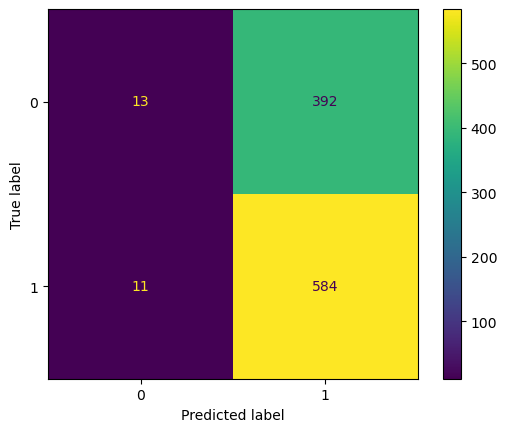

In [32]:
eval_trainer.validate(classifier_final, dataloaders=valid_loader)
validation_matrix = create_confusion_matrix(eval_trainer, classifier_final, valid)
wandb.log({"valid_conf_matrix": validation_matrix.im_})
validation_matrix

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6287059187889099
        test_loss           0.6640197038650513
       test_recall                  0.0
    test_specificity                0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

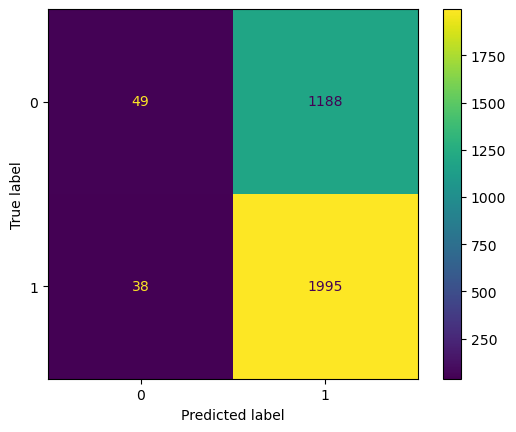

In [33]:
test_loader = utils.data.DataLoader(test, batch_size=64, num_workers=2, pin_memory=True, collate_fn=batch_collate)
eval_trainer.test(classifier_final, dataloaders=test_loader)
test_matrix = create_confusion_matrix(eval_trainer, classifier_final, test)
wandb.log({"test_conf_matrix": test_matrix.im_})
test_matrix

In [ ]:
wandb.finish()

# Interpretation
Expectation:
70% accuracy with test dataset. As this would be better than the test label imbalance of 62.2% true labels.
The expectation is higher than past projects as transformers have the potential to be better than the previous methods.
Further the expectation is that most of the accuracy comes from the majority class and not a balanced correct prediction of both classes. This is because we just select by minmum loss and not by balanced accuracy.
The model with `RotaryPositionEmbedding` should outperform `PositionEncoding` as it is an improvement to the position encodings.
More attention heads should also perform better than less, as the model should be able to generalize better.  

## Results
Experiments with learning rate of 1e-5 have overfit. This is because training loss is decreasing, but validation loss increasing. That should be because the model overfitting on the training data.
Runs with 1e-4 have no large change in loss for both training and validation. More epochs might be required or there is a problem with the implementation.

Attention heads do not seem to make a difference, because wether with larger or smaller amount of attenion heads, the loss stays the same. 

There also is no difference between embedding and encoding as between the other combinations of parameters, the loss between these methods stayed the same. The expectation was made with rotary embeddings, but embedding and encoding having the same performance might also mean that more epochs are needed.

In total transformers have not performed to the expectation. 

In comparision to RNNs transformers have the potential to be better, but also are more complex. Therefore it is harder to get improvements 
RNN had an accuracy of 0.6397 in test compared to Transformers 0.6287.

## Learning
There are a lot of customization options in transformers which can be benefitted from when you construct your own transformer layers.

Learning rate is a very important parameters as always.

Transformers and Embeddings need lots of data and time to learn. Therefore creating a foundational model should be difficult.
